In [2]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import healpy as hp

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from modules.utils import train_model_2steps, init_device
from modules.data import WeatherBenchDatasetXarrayHealpix
from modules.healpix_models import UNetSphericalHealpix
from modules.test import create_iterative_predictions_healpix
from modules.test import compute_rmse_healpix
from modules.plotting import plot_rmses

datadir = "../data/healpix/"
input_dir = datadir + "5.625deg/"
model_save_path = datadir + "models/"
pred_save_path = datadir + "predictions/"

train_years = ('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')

nodes = 12*16*16
max_lead_time = 5*24
lead_time = 6
out_features = 2
nb_timesteps = 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,2"
gpu = [0, 1]
num_workers = 10
pin_memory = True
batch_size = 120

nb_epochs = 30
learning_rate = 8e-3

obs = xr.open_mfdataset(pred_save_path + 'observations.nc', combine='by_coords')
#rmses_weyn = xr.open_dataset(datadir + 'metrics/rmses_weyn.nc')

In [3]:
from modules.data import WeatherBenchDatasetIterative

def train_model_2steps(model, device, train_generator, epochs, lr, validation_data, model_filename):    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-7, weight_decay=0, amsgrad=False)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        
        time1 = time.time()
        
        val_loss = 0
        train_loss = 0
        
        model.train()  
        for batch_idx, (batch, labels) in enumerate(train_generator):
            # Transfer to GPU
            batch1 = batch[0].to(device)
            constants1 = batch[1].to(device)
            label1 = labels[0].to(device)
            label2 = labels[1].to(device)
            
            batch_size = batch1.shape[0]
            
            # Model
            output1 = model(batch1)
            batch2 = torch.cat((output1, constants1), dim=2)
            output2 = model(batch2)
            
            loss = criterion(output1, label1) + criterion(output2, label2)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + loss.item() * batch_size
            
        train_loss = train_loss / (len(train_generator.dataset))
        train_losses.append(train_loss)
        
        model.eval()
        with torch.set_grad_enabled(False):
            index = 0
            
            for batch, labels in validation_data:
                # Transfer to GPU
                batch1 = batch[0].to(device)
                constants1 = batch[1].to(device)
                label1 = labels[0].to(device)
                label2 = labels[1].to(device)

                batch_size = batch1.shape[0]
                
                output1 = model(batch1)
                batch2 = torch.cat((output1, constants1), dim=2)
                output2 = model(batch2)
                
                val_loss = val_loss + (criterion(output1, label1).item() 
                                       + criterion(output2, label2).item()) * batch_size
                index = index + batch_size
                
        val_loss = val_loss / (len(validation_data.dataset))
        val_losses.append(val_loss)
        
        time2 = time.time()
        
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.5f}  - time: {t:2f}'
              .format(e=epoch+1+5, n_e=epochs+5, l=train_loss, v_l=val_loss, t=time2-time1))
        
        torch.save(spherical_unet.state_dict(), model_filename[:-3] + '_epoch' + str(5+epoch) + '.h5')
        
    return train_losses, val_losses


def create_iterative_predictions_healpix(model, device, dg):
    delta_t = dg.dataset.lead_time
    max_lead_time = dg.dataset.max_lead_time
    initial_lead_time = delta_t
    nodes = dg.dataset.nodes
    nside = int(np.sqrt(nodes/12))
    n_samples = dg.dataset.n_samples
    in_feat = dg.dataset.in_features
    out_feat = dg.dataset.out_features
    
    train_std =  dg.dataset.std.values[:out_feat]
    train_mean = dg.dataset.mean.values[:out_feat]
    
    data_vars = dg.dataset.mean.level.values[:out_feat]
    data_vars[:2] = np.array(['z', 't'])
    
    # Lead times
    lead_times = np.arange(delta_t, max_lead_time + delta_t, delta_t)
    
    # Lat lon coordinates
    out_lon, out_lat = hp.pix2ang(nside, np.arange(nodes), lonlat=True)
    
    # Actual times
    start = np.datetime64(dg.dataset.years[0], 'h') + np.timedelta64(initial_lead_time, 'h')
    stop = start + np.timedelta64(dg.dataset.n_samples, 'h')
    times = np.arange(start, stop)
    
    # Variables
    var_dict_out = {var: None for var in data_vars}
    
    # Radiation
    constants = np.array(dg.dataset.data.isel(level=slice(out_feat, None)).values)
    
    dataloader = dg
    predictions = []
    model.eval()
    for lead in lead_times:
        outputs = []
        state = []
        states = np.empty((n_samples, nodes, in_feat))
        
        time1 = time.time()

        for i, (sample, _) in enumerate(dataloader):
            inputs = sample[0].to(device)
            output = model(inputs)

            outputs.append(output.detach().cpu().clone().numpy()[:, :, :out_feat])
            state.append(output.detach().cpu().clone().numpy())
            
        preds = np.concatenate(outputs)
        states[:, :, :out_feat] = np.concatenate(state)
        states[:, :, out_feat:] = constants[lead:n_samples+lead, :]

        predictions.append(preds * train_std + train_mean)

        new_set = WeatherBenchDatasetIterative(states)
        dataloader = DataLoader(new_set, batch_size=batch_size, shuffle=False, num_workers=10)
        
        time2 = time.time()
        
    predictions = np.array(predictions)
    
    das = [];
    lev_idx = 0
    for var in data_vars:       
        das.append(xr.DataArray(
            predictions[:, :, :, lev_idx],
            dims=['lead_time', 'time', 'node'],
            coords={'lead_time': lead_times, 'time': times, 'node': np.arange(nodes)},
            name=var
        ))
        lev_idx += 1
            
    prediction_ds = xr.merge(das)
    prediction_ds = prediction_ds.assign_coords({'lat': out_lat, 'lon': out_lon})
    return prediction_ds

In [4]:
z500 = xr.open_mfdataset(f'{input_dir}geopotential_500/*.nc', combine='by_coords').rename({'z':'z500'})
t850 = xr.open_mfdataset(f'{input_dir}temperature_850/*.nc', combine='by_coords').rename({'t':'t850'})
rad = xr.open_mfdataset(f'{input_dir}toa_incident_solar_radiation/*.nc', combine='by_coords')
z1000 = xr.open_dataset(f'{input_dir}geopotential/geopotential_5.625deg.nc').sel(level=1000).rename({'z':'z1000'})
precipitation = xr.open_mfdataset(f'{input_dir}total_precipitation/*.nc', combine='by_coords')
clouds = xr.open_mfdataset(f'{input_dir}total_cloud_cover/*.nc', combine='by_coords')

z500 = z500.isel(time=slice(7, None))
t850 = t850.isel(time=slice(7, None))
z1000 = z1000.isel(time=slice(7, None))
clouds = clouds.isel(time=slice(7, None))

constants = xr.open_dataset(f'{input_dir}constants/constants_5.625deg.nc').rename({'orography' :'orog'})
temp = xr.DataArray(np.zeros(z500.dims['time']), coords=[('time', z500.time.values)])
constants, _ = xr.broadcast(constants, temp)

orog = constants['orog']
lsm = constants['lsm']
lats = constants['lat2d']
slt = constants['slt']


In [ ]:
predictors_mean = xr.open_dataarray(datadir + 'predictors_mean.nc')
predictors_std = xr.open_dataarray(datadir + 'predictors_std.nc')

z1000_mean = xr.open_dataarray(datadir + 'z1000_mean.nc')
z1000_std = xr.open_dataarray(datadir + 'z1000_std.nc')
cloud_mean = xr.open_dataarray(datadir + 'cloud_mean.nc')
cloud_std = xr.open_dataarray(datadir + 'cloud_std.nc')
precip_mean = xr.open_dataarray(datadir + 'precip_mean.nc')
precip_std = xr.open_dataarray(datadir + 'precip_std.nc')

const_mean = xr.open_dataarray(input_dir + 'constants/const_mean.nc')
const_std = xr.open_dataarray(input_dir + 'constants/const_std.nc')

train_mean = xr.concat((predictors_mean, z1000_mean, cloud_mean, precip_mean, const_mean), dim='level')
train_std = xr.concat((predictors_std, z1000_std, cloud_std, precip_std, const_std), dim='level')

# Z1000

Loading data into RAM
Loading data into RAM
Epoch:   6/ 35  - loss: 0.092  - val_loss: 0.05025  - time: 1899.766490
Epoch:   7/ 35  - loss: 0.037  - val_loss: 0.03814  - time: 1872.786475
Epoch:   8/ 35  - loss: 0.032  - val_loss: 0.03392  - time: 1898.574305
Epoch:   9/ 35  - loss: 0.030  - val_loss: 0.03355  - time: 1903.641420
Epoch:  10/ 35  - loss: 0.028  - val_loss: 0.03325  - time: 1901.544277
Epoch:  11/ 35  - loss: 0.027  - val_loss: 0.03195  - time: 1902.139668
Epoch:  12/ 35  - loss: 0.026  - val_loss: 0.03908  - time: 1898.726031
Epoch:  13/ 35  - loss: 0.025  - val_loss: 0.03227  - time: 1898.248451
Epoch:  14/ 35  - loss: 0.025  - val_loss: 0.03333  - time: 1898.153241
Epoch:  15/ 35  - loss: 0.024  - val_loss: 0.03078  - time: 1903.182521
Epoch:  16/ 35  - loss: 0.024  - val_loss: 0.02891  - time: 1899.589072
Epoch:  17/ 35  - loss: 0.024  - val_loss: 0.03002  - time: 1895.764374
Epoch:  18/ 35  - loss: 0.024  - val_loss: 0.03387  - time: 1901.402009
Epoch:  19/ 35  - lo

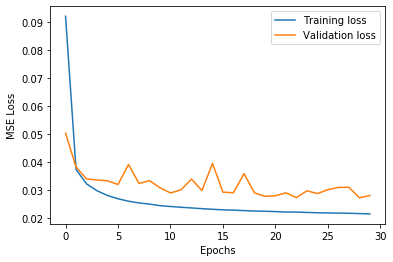

Loading data into RAM
Z500 - 0: 83.6436655513371
T850 - 0: 0.8296184596969591


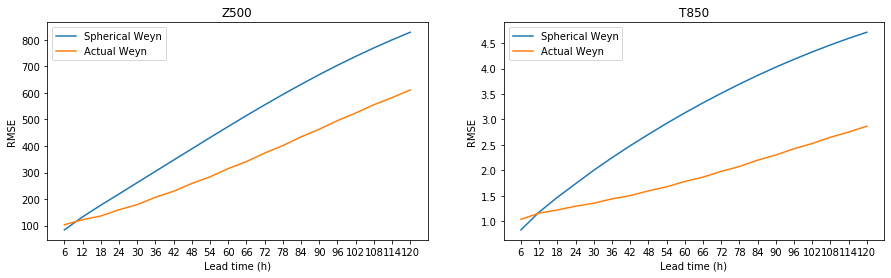

In [4]:
description = "all_const_z1000_true"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, z1000, clouds, precipitation, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 5, 6, 7, 8, 9]
in_features = len(feature_idx)
out_features = 3
ds = xr.merge([z500, t850, z1000, orog, lats, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=30, lr=learning_rate, 
                                          validation_data=dl_val, model_filename=model_filename)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()


# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
#plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test
torch.cuda.empty_cache()

In [5]:
rmse_allconst = xr.open_dataset(datadir + 'metrics/rmse_all_const.nc')
rmse_allconst_l2d6 = xr.open_dataset(datadir + 'metrics/rmse_all_const_len2_delta6.nc')

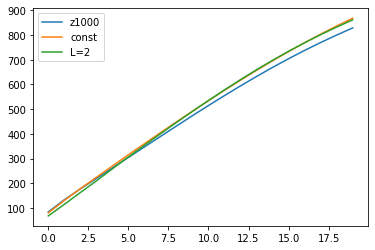

In [7]:
plt.plot(rmse.z.values, label='z1000')
plt.plot(rmse_allconst.z.values, label='const')
plt.plot(rmse_allconst_l2d6.z.values, label='L=2')

plt.legend()

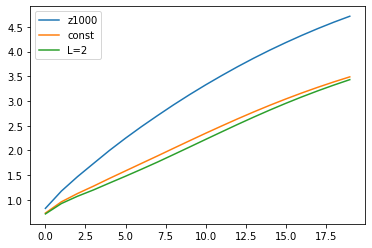

In [8]:
plt.plot(rmse.t.values, label='z1000')
plt.plot(rmse_allconst.t.values, label='const')
plt.plot(rmse_allconst_l2d6.t.values, label='L=2')

plt.legend()

# Total cloud cover

Loading data into RAM
Loading data into RAM
Epoch:   1/ 20  - loss: 0.260  - val_loss: 0.24456  - time: 1719.503968
Epoch:   2/ 20  - loss: 0.222  - val_loss: 0.22685  - time: 1709.137119
Epoch:   3/ 20  - loss: 0.217  - val_loss: 0.22458  - time: 1718.673381
Epoch:   4/ 20  - loss: 0.214  - val_loss: 0.22419  - time: 1723.491810
Epoch:   5/ 20  - loss: 0.212  - val_loss: 0.22233  - time: 1723.433450
Epoch:   6/ 20  - loss: 0.210  - val_loss: 0.22115  - time: 1729.673895
Epoch:   7/ 20  - loss: 0.209  - val_loss: 0.22409  - time: 1748.353810
Epoch:   8/ 20  - loss: 0.209  - val_loss: 0.22139  - time: 1758.796736
Epoch:   9/ 20  - loss: 0.208  - val_loss: 0.22415  - time: 1755.101356
Epoch:  10/ 20  - loss: 0.207  - val_loss: 0.22193  - time: 1757.510861
Epoch:  11/ 20  - loss: 0.207  - val_loss: 0.22238  - time: 1757.044074
Epoch:  12/ 20  - loss: 0.206  - val_loss: 0.22069  - time: 1760.402263
Epoch:  13/ 20  - loss: 0.206  - val_loss: 0.22383  - time: 1763.790151
Epoch:  14/ 20  - lo

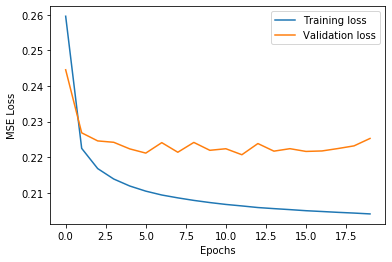

Loading data into RAM


"# Compute and save RMSE\nrmse = compute_rmse_healpix(preds, obs).load()\nrmse.to_netcdf(rmse_filename)\n\n# Show RMSE\nprint('Z500 - 0:', rmse.z.values[0])\nprint('T850 - 0:', rmse.t.values[0])\nplot_rmses(rmse, rmses_weyn, lead_time)\n\ndel testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,\ntorch.cuda.empty_cache()"

In [4]:
description = "all_const_clouds"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, z1000, clouds, precipitation, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 3, 5, 6, 7, 8, 9]
in_features = len(feature_idx)
out_features = 3
ds = xr.merge([z500, t850, clouds, orog, lats, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]


# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=20, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

'''# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)'''

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test
torch.cuda.empty_cache()

# Total precipitation

Loading data into RAM
Loading data into RAM
Epoch:   1/ 20  - loss: 0.485  - val_loss: 0.56406  - time: 1703.460772
Epoch:   2/ 20  - loss: 0.441  - val_loss: 0.55873  - time: 1693.877647
Epoch:   3/ 20  - loss: 0.431  - val_loss: 0.55638  - time: 1691.296984
Epoch:   4/ 20  - loss: 0.423  - val_loss: 0.55649  - time: 1713.167230
Epoch:   5/ 20  - loss: 0.415  - val_loss: 0.55595  - time: 1721.843551
Epoch:   6/ 20  - loss: 0.408  - val_loss: 0.55654  - time: 1719.887719
Epoch:   7/ 20  - loss: 0.403  - val_loss: 0.55649  - time: 1734.671881
Epoch:   8/ 20  - loss: 0.398  - val_loss: 0.56305  - time: 1724.345230
Epoch:   9/ 20  - loss: 0.393  - val_loss: 0.55987  - time: 1724.244901
Epoch:  10/ 20  - loss: 0.389  - val_loss: 0.55973  - time: 1724.652073
Epoch:  11/ 20  - loss: 0.386  - val_loss: 0.55881  - time: 1725.858865
Epoch:  12/ 20  - loss: 0.382  - val_loss: 0.56007  - time: 1729.578691
Epoch:  13/ 20  - loss: 0.380  - val_loss: 0.56374  - time: 1755.995436
Epoch:  14/ 20  - lo

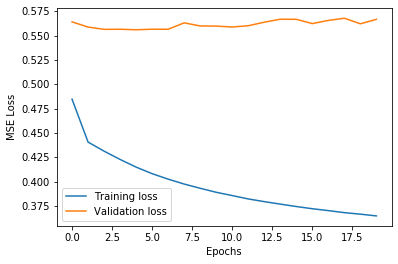

Loading data into RAM


In [4]:
description = "all_const_precip"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, z1000, clouds, precipitation orog, lats, lsm, slt, rad
feature_idx = [0, 1, 4, 5, 6, 7, 8, 9]
in_features = len(feature_idx)
out_features = 3
ds = xr.merge([z500, t850, precipitation, orog, lats, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]


# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=20, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

'''# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)'''

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test
torch.cuda.empty_cache()

# Both

Loading data into RAM
Loading data into RAM
Epoch:   1/ 20  - loss: 0.539  - val_loss: 0.59117  - time: 1837.107403
Epoch:   2/ 20  - loss: 0.492  - val_loss: 0.58193  - time: 1839.630430
Epoch:   3/ 20  - loss: 0.484  - val_loss: 0.58211  - time: 1844.413175
Epoch:   4/ 20  - loss: 0.477  - val_loss: 0.58097  - time: 1855.131849
Epoch:   5/ 20  - loss: 0.471  - val_loss: 0.58070  - time: 1854.044208
Epoch:   6/ 20  - loss: 0.466  - val_loss: 0.58368  - time: 1856.465122
Epoch:   7/ 20  - loss: 0.461  - val_loss: 0.58031  - time: 1855.325524
Epoch:   8/ 20  - loss: 0.458  - val_loss: 0.58008  - time: 1856.707074
Epoch:   9/ 20  - loss: 0.454  - val_loss: 0.58104  - time: 1855.729289
Epoch:  10/ 20  - loss: 0.452  - val_loss: 0.58062  - time: 1857.195601
Epoch:  11/ 20  - loss: 0.449  - val_loss: 0.58035  - time: 1854.485878
Epoch:  12/ 20  - loss: 0.447  - val_loss: 0.58507  - time: 1855.410909
Epoch:  13/ 20  - loss: 0.445  - val_loss: 0.58296  - time: 1856.572176
Epoch:  14/ 20  - lo

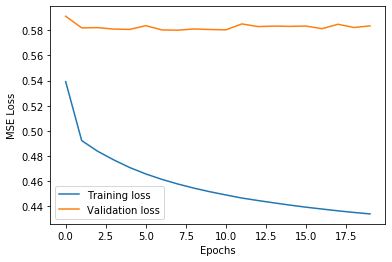

Loading data into RAM


In [5]:
description = "all_const_clouds_precip"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, z1000, clouds, precipitation orog, lats, lsm, slt, rad
feature_idx = [0, 1, 3, 4, 5, 6, 7, 8, 9]
in_features = len(feature_idx)
out_features = 4
ds = xr.merge([z500, t850, clouds, precipitation, orog, lats, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]


# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=20, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

'''# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)'''

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test
torch.cuda.empty_cache()

# Comparison

In [ ]:
rmse_const = xr.open_dataset(datadir + 'metrics/rmse_all_const.nc')
rmse_z1000 = xr.open_dataset(datadir + 'metrics/rmse_all_const_z1000_true.nc')

f, axs = plt.subplots(1, 2, figsize=(17, 6))


lead_times = np.arange(lead_time, max_lead_time+lead_time, lead_time)
xlabels = [str(t) if t%4 == 0 else '' for t in lead_times] if lead_times[0] < 12 else lead_times

axs[0].plot(lead_times, rmse_const.z.values, label='All static features')
axs[0].plot(lead_times, rmse_z1000.z.values, label='All static features + Z1000')

axs[1].plot(lead_times, rmse_const.t.values, label='All static features')
axs[1].plot(lead_times, rmse_z1000.t.values, label='All static features + Z1000')


axs[0].set_xticks(lead_times)
axs[1].set_xticks(lead_times)
axs[0].set_xticklabels(xlabels)
axs[1].set_xticklabels(xlabels)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[0].set_xlabel('Lead time [h]', fontsize='18')
axs[1].set_xlabel('Lead time [h]', fontsize='18')
axs[0].set_ylabel('RMSE [$m^2 s^{-2}$]', fontsize='18')
axs[1].set_ylabel('RMSE [K]', fontsize='18')
axs[0].set_title('Z500', fontsize='22')
axs[1].set_title('T850', fontsize='22')
axs[0].legend(fontsize=16)
axs[1].legend(fontsize=16)

plt.tight_layout()

#plt.savefig('rmse_z1000_comparison_.eps', format='eps', bbox_inches='tight')

plt.show()

In [ ]:
corr_const = xr.open_dataset(datadir + 'metrics/corr_all_const.nc')
corr_z1000 = xr.open_dataset(datadir + 'metrics/corr_all_const_z1000_true.nc')

f, axs = plt.subplots(1, 2, figsize=(17, 6), sharey=True)

xlabels = [str(t) if t%4 == 0 else '' for t in lead_times] if lead_times[0] < 12 else lead_times

axs[0].plot(lead_times, corr_const.z.values, label='All static features')
axs[0].plot(lead_times, corr_z1000.z.values, label='All static features + Z1000')

axs[1].plot(lead_times, corr_const.t.values, label='All static features')
axs[1].plot(lead_times, corr_z1000.t.values, label='All static features + Z1000')


axs[0].set_xticks(lead_times)
axs[1].set_xticks(lead_times)
axs[0].set_xticklabels(xlabels)
axs[1].set_xticklabels(xlabels)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[0].set_xlabel('Lead time [h]', fontsize='18')
axs[1].set_xlabel('Lead time [h]', fontsize='18')
axs[0].set_ylabel('R2', fontsize='18')
axs[0].set_title('Z500', fontsize='22')
axs[1].set_title('T850', fontsize='22')
axs[0].legend(fontsize=16)
axs[1].legend(fontsize=16)

plt.tight_layout()

#plt.savefig('corr_z1000_comparison_.eps', format='eps', bbox_inches='tight')

plt.show()

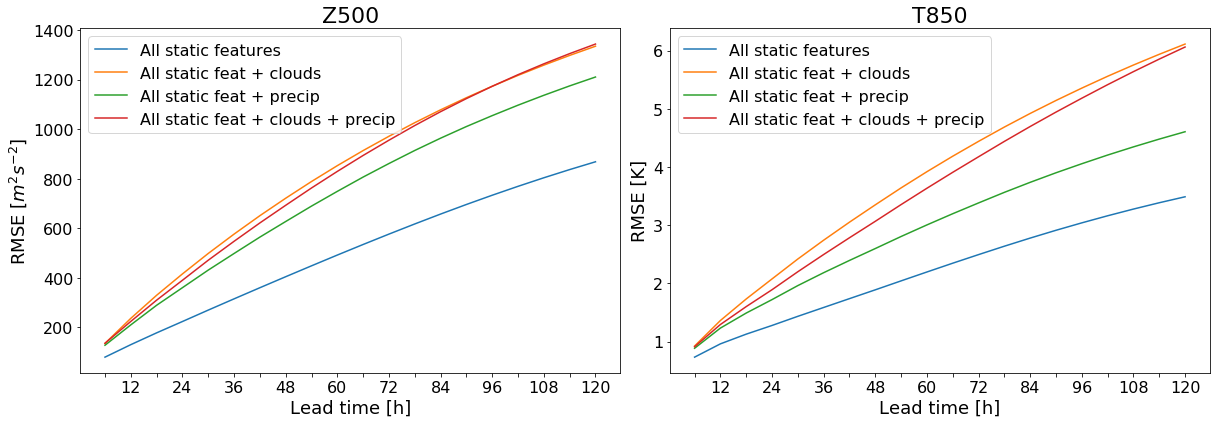

In [7]:
rmse_all_const = xr.open_dataset(datadir + 'metrics/rmse_' + 'all_const' + '.nc')
rmse_all_const_clouds = xr.open_dataset(datadir + 'metrics/rmse_' + 'all_const_clouds' + '.nc')
rmse_all_const_precip = xr.open_dataset(datadir + 'metrics/rmse_' + 'all_const_precip' + '.nc')
rmse_all_const_clouds_precip = xr.open_dataset(datadir + 'metrics/rmse_' + 'all_const_clouds_precip' + '.nc')

f, axs = plt.subplots(1, 2, figsize=(17, 6))
lead_times = np.arange(6, max_lead_time + 6, 6)

xlabels = [str(t) if t%4 == 0 else '' for t in lead_times] if lead_times[0] < 12 else lead_times

axs[0].plot(lead_times, rmse_all_const.z.values, label='All static features')
axs[0].plot(lead_times, rmse_all_const_clouds.z.values, label='All static feat + clouds')
axs[0].plot(lead_times, rmse_all_const_precip.z.values, label='All static feat + precip')
axs[0].plot(lead_times, rmse_all_const_clouds_precip.z.values, label='All static feat + clouds + precip')

axs[1].plot(lead_times, rmse_all_const.t.values, label='All static features')
axs[1].plot(lead_times, rmse_all_const_clouds.t.values, label='All static feat + clouds')
axs[1].plot(lead_times, rmse_all_const_precip.t.values, label='All static feat + precip')
axs[1].plot(lead_times, rmse_all_const_clouds_precip.t.values, label='All static feat + clouds + precip')

axs[0].set_xticks(lead_times)
axs[1].set_xticks(lead_times)
axs[0].set_xticklabels(xlabels)
axs[1].set_xticklabels(xlabels)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[0].set_xlabel('Lead time [h]', fontsize='18')
axs[1].set_xlabel('Lead time [h]', fontsize='18')
axs[0].set_ylabel('RMSE [$m^2 s^{-2}$]', fontsize='18')
axs[1].set_ylabel('RMSE [K]', fontsize='18')
axs[0].set_title('Z500', fontsize='22')
axs[1].set_title('T850', fontsize='22')
axs[0].legend(fontsize=16, loc='upper left')
axs[1].legend(fontsize=16)

plt.tight_layout()

#plt.savefig('rmse_clouds_rain.eps', format='eps', bbox_inches='tight')

plt.show()

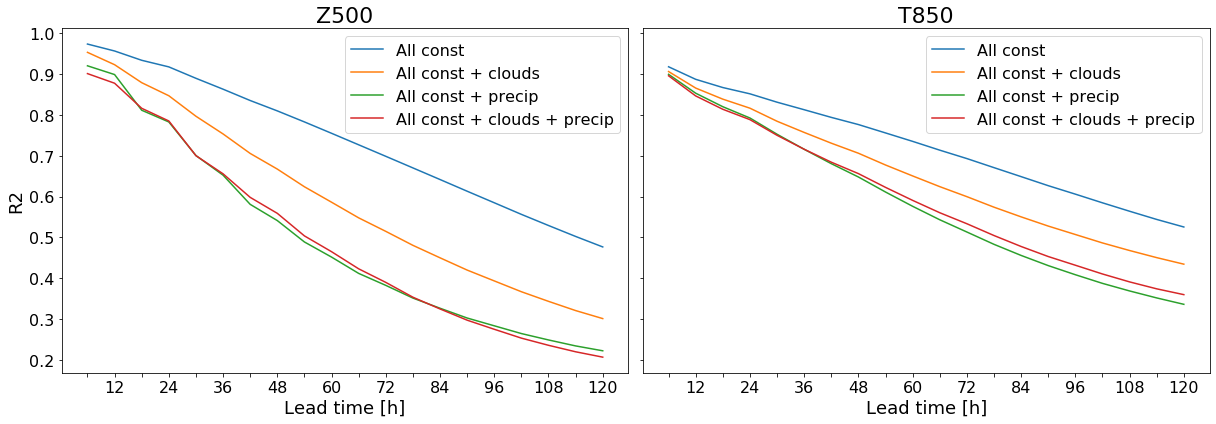

In [23]:
corr_all_const = xr.open_dataset(datadir + 'metrics/corr_' + 'all_const' + '.nc')
corr_all_const_clouds = xr.open_dataset(datadir + 'metrics/corr_' + 'all_const_clouds' + '.nc')
corr_all_const_precip = xr.open_dataset(datadir + 'metrics/corr_' + 'all_const_precip' + '.nc')
corr_all_const_clouds_precip = xr.open_dataset(datadir + 'metrics/corr_' + 'all_const_clouds_precip' + '.nc')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6), sharey=True)
lead_times = np.arange(6, max_lead_time + 6, 6)

xlabels = [str(t) if t%4 == 0 else '' for t in lead_times] if lead_times[0] < 12 else lead_times

ax1.plot(lead_times, corr_all_const.z.values, label='All const')
ax1.plot(lead_times, corr_all_const_clouds.z.values, label='All const + clouds')
ax1.plot(lead_times, corr_all_const_precip.z.values, label='All const + precip')
ax1.plot(lead_times, corr_all_const_clouds_precip.z.values, label='All const + clouds + precip')

ax2.plot(lead_times, corr_all_const.t.values, label='All const')
ax2.plot(lead_times, corr_all_const_clouds.t.values, label='All const + clouds')
ax2.plot(lead_times, corr_all_const_precip.t.values, label='All const + precip')
ax2.plot(lead_times, corr_all_const_clouds_precip.t.values, label='All const + clouds + precip')


ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax1.set_xticklabels(xlabels)
ax2.set_xticklabels(xlabels)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xlabel('Lead time [h]', fontsize='18')
ax2.set_xlabel('Lead time [h]', fontsize='18')
ax1.set_ylabel('R2', fontsize='18')
ax1.set_title('Z500', fontsize='22')
ax2.set_title('T850', fontsize='22')
ax1.legend(fontsize=16, loc='upper right')
ax2.legend(fontsize=16, loc='upper right')

plt.tight_layout()

#plt.savefig('corr_clouds_rain.eps', format='eps', bbox_inches='tight')

plt.show()

In [ ]:
from modules.data import hp_to_equiangular
from modules.plotting import plot_signal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from matplotlib.axes import Axes
from matplotlib import cm, colors
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

from modules.test import compute_rmse_healpix, compute_relBIAS, compute_rSD, compute_R2, compute_anomalies

# Inputs
prediction_path = '../data/healpix/predictions/'
metrics_path = '../data/healpix/metrics/'
figures_path = '../data/healpix/figures/'

resolution = 5.625
lead_time = 6
len_sqce = 2
max_lead_time = 5*24
model_description = "all_const_len{}_delta{}".format(len_sqce, lead_time)
start_time = len_sqce * lead_time - 6
end_time = (6-lead_time) if (6-lead_time) > 0 else None

def plot_skillmaps(rmse_map, rsd_map, rbias_map, corr_map, model_description, lead_times, resolution, 
                   output_dir):
    for i, lead in enumerate(lead_times[0:1]):  
        
        rmse_min = 0
        rmse_max = 1
        
        rsd_min = 0
        rsd_max = 2

        rbias_min = -2
        rbias_max = 2

        corr_min = 0
        corr_max = 1

        rmse_equi = hp_to_equiangular(rmse_map.isel(lead_time=i), resolution)
        rsd_equi = hp_to_equiangular(rsd_map.isel(lead_time=i), resolution)
        rbias_equi = hp_to_equiangular(rbias_map.isel(lead_time=i), resolution)
        corr_equi = hp_to_equiangular(corr_map.isel(lead_time=i), resolution)

        proj = ccrs.PlateCarree()

        f, axs = plt.subplots(4, 2, figsize=(15, 15), subplot_kw=dict(projection=proj))
        #f.suptitle('Skillmaps between forecast and observation, lead time: {}h'.format(lead), fontsize=26, y=1.05, x=0.45)
        
        cols = ['Cloud cover', 'Total precipitation']

        for ax, col in zip(axs[0, :], cols):
            ax.set_title(col, fontsize=24, y=1.08)
        
        plot_signal(f, sample=rmse_equi, var='tcc', vmin=0, vmax=0.6, proj=proj, ax=axs[0, 0], 
                    cmap='Reds', colorbar=True, cbar_label='', extend='neither')
        plot_signal(f, sample=rmse_equi, var='tp', vmin=0, vmax=2.5, proj=proj, ax=axs[0, 1], 
                    cmap='Reds', colorbar=True, cbar_label='relRMSE', extend='max')

        plot_signal(f, sample=rbias_equi, var='tcc', vmin=-0.1, vmax=0.1, proj=proj, ax=axs[1, 0], 
                    cmap='RdBu_r', colorbar=True, cbar_label='', extend='neither')
        plot_signal(f, sample=rbias_equi, var='tp', vmin=-3, vmax=3, proj=proj, ax=axs[1, 1], 
                    cmap='RdBu_r', colorbar=True, cbar_label='relBIAS', extend='max')

        plot_signal(f, sample=rsd_equi, var='tcc', vmin=0.5, vmax=1.5, proj=proj, ax=axs[2, 0], 
                    cmap='PuOr_r', colorbar=True, cbar_label='', extend='neither')
        plot_signal(f, sample=rsd_equi, var='tp', vmin=-0.5, vmax=2.5, proj=proj, ax=axs[2, 1], 
                    cmap='PuOr_r', colorbar=True, cbar_label='rSD', extend='neither')

        plot_signal(f, sample=corr_equi, var='tcc', vmin=corr_min, vmax=corr_max, proj=proj, ax=axs[3, 0], 
                    cmap='Greens', colorbar=True, cbar_label='', extend='neither')
        plot_signal(f, sample=corr_equi, var='tp', vmin=corr_min, vmax=corr_max, proj=proj, ax=axs[3, 1], 
                    cmap='Greens', colorbar=True, cbar_label='R2', extend='neither')


        plt.tight_layout(pad=-1)
        filename = model_description + '_' + str(i) + '_maps.png'
        #plt.savefig('clouds_rain_maps.png', bbox_inches='tight')

        plt.show()

In [ ]:
model_description = "all_const_clouds_precip"

DATADIR = '../data/healpix/'

obs_rc = xr.open_mfdataset(DATADIR + 'predictions/observations_rain_clouds.nc', combine='by_coords')
pred_rc = xr.open_mfdataset(DATADIR + 'predictions/spherical_unet_' + model_description + '.nc', 
                            combine='by_coords')[['tcc', 'tp']]

rmse_map = compute_rmse_healpix(pred_rc, obs_rc, dims=('time'))
obs_rmse = np.sqrt(((obs_rc)**2).mean(('time')))
rmse_map_norm = rmse_map / obs_rmse
corr_map = compute_R2(pred_rc, obs_rc, dims=('time'))
rbias_map = compute_relBIAS(pred_rc, obs_rc, dims=('time'))
rsd_map = compute_rSD(pred_rc, obs_rc, dims=('time'))

In [ ]:
plot_skillmaps(rmse_map_norm, rsd_map, rbias_map, corr_map, model_description, lead_times, resolution, 
               output_dir=figures_path)